In [2]:
#Import Required Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
#Load Dataset
df = pd.read_csv("stock_details_5_years.csv")
df = df.sort_values(by=["Company", "Date"])

In [4]:
#Preprocess Data (Add Technical Indicators)
def add_technical_indicators(data):
    data["SMA_10"] = data["Close"].rolling(window=10).mean()
    data["SMA_50"] = data["Close"].rolling(window=50).mean()
    data["EMA_10"] = data["Close"].ewm(span=10, adjust=False).mean()
    data["EMA_50"] = data["Close"].ewm(span=50, adjust=False).mean()
    data["RSI"] = compute_rsi(data["Close"], 14)
    return data

In [5]:
# Function to compute RSI
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

In [6]:
# Apply indicators to each company
df = df.groupby("Company", group_keys=False).apply(add_technical_indicators).reset_index(drop=True)
df.dropna(inplace=True)  # Drop NaN values from rolling calculations

C:\Users\Dhiraj Kumar Sah\AppData\Local\Temp\ipykernel_24584\319320674.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("Company", group_keys=False).apply(add_technical_indicators).reset_index(drop=True)


In [7]:
# Prepare Training Data
companies = df["Company"].unique()
all_X_train, all_y_train = [], []
scalers = {}  # Store scalers for each company
sequence_length = 50
features = ["Close", "SMA_10", "SMA_50", "EMA_10", "EMA_50", "RSI"]

for company in companies:
    company_data = df[df["Company"] == company][features].values  # Use new features
    
    # Normalize data
    scaler = MinMaxScaler()
    company_data_scaled = scaler.fit_transform(company_data)
    scalers[company] = scaler  # Store scaler for later inverse transformation
    
    # Prepare sequences for training
    X_train, y_train = [], []
    for i in range(sequence_length, len(company_data_scaled)):
        X_train.append(company_data_scaled[i-sequence_length:i])
        y_train.append(company_data_scaled[i, 0])  # Predict 'Close' price
    
    all_X_train.extend(X_train)
    all_y_train.extend(y_train)

In [8]:
# Convert to numpy arrays
all_X_train, all_y_train = np.array(all_X_train), np.array(all_y_train)

In [9]:
# Check if model exists
model_path = "lstm_stock_model_with_indicators.keras"
if os.path.exists(model_path):
    print("Loading existing model...")
    model = load_model(model_path)
else:
    # Build and Train LSTM Model
    model = Sequential([
        LSTM(units=100, return_sequences=True, input_shape=(all_X_train.shape[1], all_X_train.shape[2])),
        BatchNormalization(),
        Dropout(0.1),
        
        LSTM(units=100, return_sequences=True),
        BatchNormalization(),
        Dropout(0.1),
        
        LSTM(units=50, return_sequences=False),
        BatchNormalization(),
        Dropout(0.1),
        
        Dense(units=50, activation='relu'),
        Dense(units=1, activation='linear')
    ])
    
    model.compile(optimizer="adam", loss="mean_squared_error")
    
    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

    # Train the model
    model.fit(all_X_train, all_y_train, epochs=100, batch_size=32, verbose=1, callbacks=[early_stopping])
    model.save(model_path)
    print("Model trained and saved.")

Loading existing model...


Enter the company name for trend visualization:  GOOGL


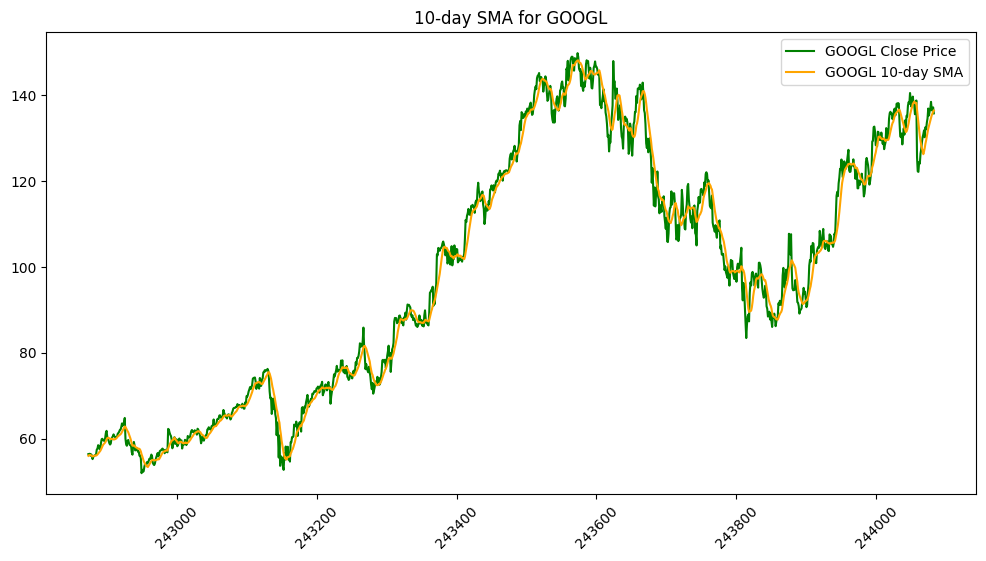

In [11]:
# Plot Moving Averages Trend
company_name = input("Enter the company name for trend visualization: ")
if company_name in companies:
  company_data = df[df["Company"] == company_name]
  
  # Plot SMA_10 vs Close
  plt.figure(figsize=(12, 6))
  plt.plot(company_data["Close"], label=f"{company_name} Close Price", color='g')
  plt.plot(company_data["SMA_10"], label=f"{company_name} 10-day SMA", color='orange')
  plt.title(f"10-day SMA for {company_name}")
  plt.legend()
  plt.xticks(rotation=45)
  plt.show()
else:
  print("Company not found in dataset.")

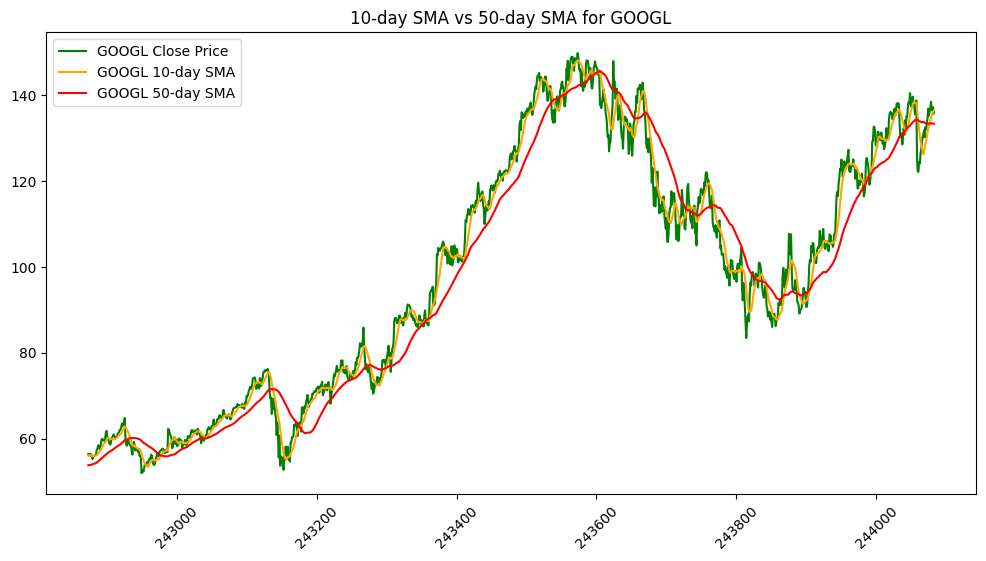

In [12]:
# Plot SMA_10 vs SMA_50 vs Date
plt.figure(figsize=(12, 6))
plt.plot(company_data["Close"], label=f"{company_name} Close Price", color='g')
plt.plot(company_data["SMA_10"], label=f"{company_name} 10-day SMA", color='orange')
plt.plot(company_data["SMA_50"], label=f"{company_name} 50-day SMA", color='r')
plt.title(f"10-day SMA vs 50-day SMA for {company_name}")
plt.legend()
plt.xticks(rotation=45)
plt.show()

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step


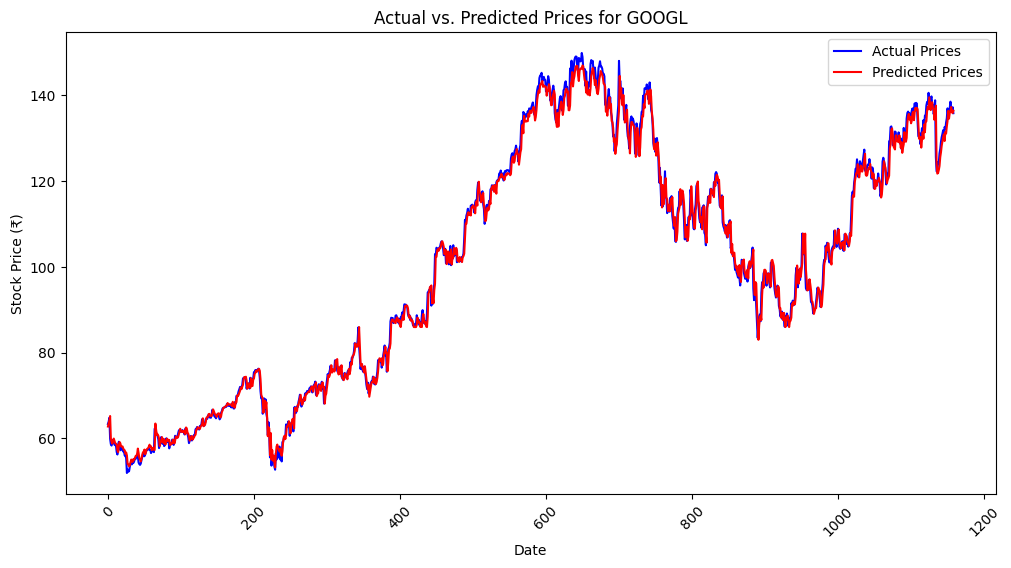

Mean Absolute Error (MAE) for GOOGL: 1.508543309996105
Mean Absolute Percentage Error (MAPE) for GOOGL: 1.4883489359626105 %
R-Squared Score (R²) for GOOGL: 0.9947354701779559


In [13]:
# Plot Actual vs. Predicted Prices & compute accuracy
X_test, y_test = [], []
company_data_scaled = scalers[company_name].transform(company_data[features].values)
for i in range(sequence_length, len(company_data_scaled)):
    X_test.append(company_data_scaled[i-sequence_length:i])
    y_test.append(company_data_scaled[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

predicted_prices = model.predict(X_test)
predicted_prices_full = np.zeros((len(predicted_prices), len(features)))
predicted_prices_full[:, 0] = predicted_prices.flatten()
predicted_prices = scalers[company_name].inverse_transform(predicted_prices_full)[:, 0]
actual_prices = company_data["Close"].iloc[sequence_length:].values

plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label="Actual Prices", color='blue')
plt.plot(predicted_prices, label="Predicted Prices", color='red')
plt.xlabel("Date")
plt.ylabel("Stock Price (₹)")
plt.title(f"Actual vs. Predicted Prices for {company_name}")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Compute Accuracy
mae = mean_absolute_error(actual_prices, predicted_prices)
mape = mean_absolute_percentage_error(actual_prices, predicted_prices) * 100
r2 = r2_score(actual_prices, predicted_prices)
print(f"Mean Absolute Error (MAE) for {company_name}: {mae}")
print(f"Mean Absolute Percentage Error (MAPE) for {company_name}: {mape} %")
print(f"R-Squared Score (R²) for {company_name}: {r2}")